In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


2025-04-16 02:45:41.407817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744771541.620400    2078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744771541.682322    2078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Paths
base_path = "/kaggle/input/odir5k/ODIR-5K"
img_dir = os.path.join(base_path, "ODIR-5K_Training_Images", "ODIR-5K_Training_Dataset")
annotations_path = os.path.join(base_path, "ODIR-5K_Training_Annotations(Updated)_V2.xlsx")

# annotations
df = pd.read_excel(annotations_path)

# columns
diagnoses = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Image paths
df['image_path'] = df['ID'].astype(str) + '_right.jpg'
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(img_dir, x))
df = df[df['image_path'].apply(os.path.exists)]

# data
image_paths = df['image_path'].values
labels = df[diagnoses].values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,image_path
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_...
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_...
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_...
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_...
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_...


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_image).map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1744771554.710990    2078 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Initially freeze

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(8, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  tf.keras.metrics.AUC(name='auc'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,045,704 (26.88 MB)

 Trainable params: 8,200 (32.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [5]:
checkpoint = ModelCheckpoint("best_densenet.keras", monitor='val_auc', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[checkpoint, early_stopping, reduce_lr])


Epoch 1/20


I0000 00:00:1744771590.041689    2109 service.cc:148] XLA service 0x799ac8003d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744771590.042575    2109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744771593.444628    2109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/88 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - auc: 0.4604 - loss: 0.8885 - precision: 0.1019 - recall: 0.2723    

I0000 00:00:1744771606.062363    2109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - auc: 0.6660 - loss: 0.5118 - precision: 0.2375 - recall: 0.2044
Epoch 1: val_auc improved from -inf to 0.79265, saving model to best_densenet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 706ms/step - auc: 0.6666 - loss: 0.5110 - precision: 0.2381 - recall: 0.2042 - val_auc: 0.7927 - val_loss: 0.3512 - val_precision: 0.4194 - val_recall: 0.0157 - learning_rate: 0.0010
Epoch 2/20
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.7684 - loss: 0.3817 - precision: 0.3561 - recall: 0.1688
Epoch 2: val_auc improved from 0.79265 to 0.81021, saving model to best_densenet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - auc: 0.7686 - loss: 0.3814 - precision: 0.3566 - recall: 0.1689 - val_auc: 0.8102 - val_loss: 0.3347 - val_precision: 0.5169 - val_recall: 0.0554 - learning_rate: 0.0010
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.7992 - loss: 0.3514 - precision: 0.4272 - recall: 0.1898
Epoch 3: val_auc improved from 0.81021 to 0.82277, saving

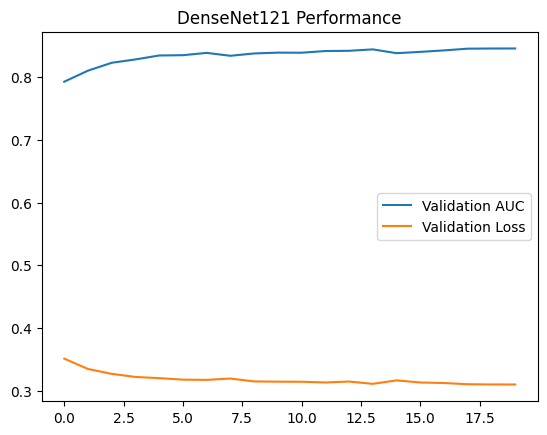

In [6]:
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("DenseNet121 Performance")
plt.show()


In [7]:
import os
import glob
import pandas as pd
import tensorflow as tf

test_dir = "/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Testing_Images/ODIR-5K_Testing_Images"

left_images = sorted(glob.glob(os.path.join(test_dir, "*_left.jpg")))
right_images = sorted(glob.glob(os.path.join(test_dir, "*_right.jpg")))

assert len(left_images) == len(right_images), "Left/Right image count mismatch!"
ids = [os.path.basename(p).split("_")[0] for p in right_images]

left_tensor = tf.constant(left_images, dtype=tf.string)
right_tensor = tf.constant(right_images, dtype=tf.string)


In [8]:
def load_dual_image(left_path, right_path):
    def load_and_preprocess(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = img / 255.0
        return img

    return load_and_preprocess(left_path), load_and_preprocess(right_path)


In [9]:
test_ds = tf.data.Dataset.from_tensor_slices((left_tensor, right_tensor))
test_ds = test_ds.map(load_dual_image).batch(32).prefetch(tf.data.AUTOTUNE)

print("Test dataset size:", tf.data.experimental.cardinality(test_ds).numpy())


Test dataset size: 16


In [10]:
# Load trained model weights
model.load_weights("best_densenet.keras")

# Make predictions
predictions = model.predict(test_ds, verbose=1)
binary_preds = (predictions > 0.3).astype(int)


16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step 


In [11]:
model.load_weights("best_densenet.keras")


predictions = model.predict(test_ds)
binary_preds = (predictions > 0.3).astype(int)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step


In [12]:
columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
pred_df = pd.DataFrame(binary_preds, columns=columns)

pred_df.insert(0, 'ID', ids)

pred_df.to_csv("submission_dual_input.csv", index=False)


pred_df.head()


,ID,N,D,G,C,A,H,M,O
0,1000,1,0,0,0,0,0,0,0
1,1001,0,1,0,0,0,0,0,1
2,1002,1,1,0,0,0,0,0,0
3,1003,0,1,0,0,0,0,0,1
4,1004,0,1,0,0,0,0,0,1


In [13]:


from PIL import Image
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [14]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return np.array(img) / 255.0

def create_image_paths(row, data_path):
    left_img_path = os.path.join(data_path, row['Left-Fundus'])
    right_img_path = os.path.join(data_path, row['Right-Fundus'])
    return left_img_path, right_img_path

def create_labels(row, diagnoses):
    return [row[diag] for diag in diagnoses]

def prepare_data(annotations_df, data_path, diagnoses, target_size=(224, 224)):
    X_left, X_right, y = [], [], []
    for _, row in annotations_df.iterrows():
        left_img_path, right_img_path = create_image_paths(row, data_path)
        if os.path.exists(left_img_path) and os.path.exists(right_img_path):
            try:
                X_left.append(load_and_preprocess_image(left_img_path, target_size))
                X_right.append(load_and_preprocess_image(right_img_path, target_size))
                y.append(create_labels(row, diagnoses))
            except Exception as e:
                print(f"Error loading ID {row['ID']}: {e}")
    return np.array(X_left), np.array(X_right), np.array(y)


In [15]:
annotations_path = "/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_Annotations(Updated)_V2.xlsx"
data_path = "/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Training_Images/ODIR-5K_Training_Dataset"

annotations_df = pd.read_excel(annotations_path)
diagnoses = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']


In [16]:
annotations_df[['ID', 'Left-Fundus', 'Right-Fundus']].head()


,ID,Left-Fundus,Right-Fundus
0,0,0_left.jpg,0_right.jpg
1,1,1_left.jpg,1_right.jpg
2,2,2_left.jpg,2_right.jpg
3,3,3_left.jpg,3_right.jpg
4,4,4_left.jpg,4_right.jpg


In [17]:
# Create a new DataFrame with full paths
annotations_df['left_path'] = annotations_df['Left-Fundus'].apply(lambda x: os.path.join(data_path, x))
annotations_df['right_path'] = annotations_df['Right-Fundus'].apply(lambda x: os.path.join(data_path, x))
annotations_df['label'] = annotations_df[diagnoses].values.tolist()  # Combine 8 binary columns into a list


In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_dual_vgg16_model(input_shape=(224, 224, 3), num_classes=8):
    left_input = Input(shape=input_shape, name='left_eye_input')
    right_input = Input(shape=input_shape, name='right_eye_input')

    base_model_left = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, name='vgg16_left')
    base_model_right = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, name='vgg16_right')

    for layer in base_model_left.layers:
        layer.trainable = False
    for layer in base_model_right.layers:
        layer.trainable = False

    left_features = base_model_left(left_input)
    right_features = base_model_right(right_input)

    left_flat = Flatten()(left_features)
    right_flat = Flatten()(right_features)

    merged = concatenate([left_flat, right_flat])
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.3)(x)  # slightly lower dropout
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=[left_input, right_input], outputs=output)
    
    model.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )
    return model


In [26]:
for layer in model_vgg.layers:
    layer.trainable = True

model_vgg.compile(
    optimizer=Adam(1e-5),  # lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)


In [27]:
history_finetune = model_vgg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.3434 - auc: 0.7790 - loss: 0.3574 - precision: 0.3849 - recall: 0.1121
Epoch 1: val_auc did not improve from 0.84556
88/88 ━━━━━━━━━━━━━━━━━━━━ 62s 475ms/step - accuracy: 0.3435 - auc: 0.7790 - loss: 0.3574 - precision: 0.3849 - recall: 0.1122 - val_accuracy: 0.4043 - val_auc: 0.8169 - val_loss: 0.3346 - val_precision: 1.0000 - val_recall: 0.0145
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3307 - auc: 0.7803 - loss: 0.3552 - precision: 0.3834 - recall: 0.1162
Epoch 2: val_auc did not improve from 0.84556
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 408ms/step - accuracy: 0.3309 - auc: 0.7803 - loss: 0.3551 - precision: 0.3837 - recall: 0.1162 - val_accuracy: 0.3957 - val_auc: 0.8156 - val_loss: 0.3352 - val_precision: 0.6250 - val_recall: 0.0181
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3449 - auc: 0.7863 - loss: 0.3535 - precision: 0.4067 - recall: 0.1338
Epoch 3: val_auc did not improve 

In [28]:
history_finetune = model_vgg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3587 - auc: 0.7861 - loss: 0.3507 - precision: 0.4186 - recall: 0.1277
Epoch 1: val_auc did not improve from 0.84556
88/88 ━━━━━━━━━━━━━━━━━━━━ 49s 412ms/step - accuracy: 0.3587 - auc: 0.7861 - loss: 0.3507 - precision: 0.4186 - recall: 0.1277 - val_accuracy: 0.4014 - val_auc: 0.8172 - val_loss: 0.3337 - val_precision: 0.8750 - val_recall: 0.0169
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3487 - auc: 0.7896 - loss: 0.3504 - precision: 0.4008 - recall: 0.1238
Epoch 2: val_auc did not improve from 0.84556
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 413ms/step - accuracy: 0.3487 - auc: 0.7895 - loss: 0.3504 - precision: 0.4007 - recall: 0.1238 - val_accuracy: 0.3971 - val_auc: 0.8164 - val_loss: 0.3342 - val_precision: 0.8824 - val_recall: 0.0181
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3406 - auc: 0.7870 - loss: 0.3518 - precision: 0.4046 - recall: 0.1147
Epoch 3: val_auc did not improve 

In [72]:
import tensorflow as tf
import os
import glob
import numpy as np
import pandas as pd

# Test directory
test_dir = "/kaggle/input/odir5k/ODIR-5K/ODIR-5K_Testing_Images/ODIR-5K_Testing_Images"

# Get image paths
left_paths = sorted(glob.glob(os.path.join(test_dir, "*_left.jpg")))
right_paths = sorted(glob.glob(os.path.join(test_dir, "*_right.jpg")))
assert len(left_paths) == len(right_paths), "Mismatch in number of left and right images"

# Extract IDs for submission
ids = [os.path.basename(p).split("_")[0] for p in right_paths]

# STEP 1: Create numpy arrays for both eyes first
left_images = []
right_images = []

for left_path, right_path in zip(left_paths, right_paths):
    # Process left image
    left_img = tf.io.read_file(left_path)
    left_img = tf.image.decode_jpeg(left_img, channels=3)
    left_img = tf.image.resize(left_img, (224, 224))
    left_img = left_img / 255.0
    left_images.append(left_img.numpy())
    
    # Process right image
    right_img = tf.io.read_file(right_path)
    right_img = tf.image.decode_jpeg(right_img, channels=3)
    right_img = tf.image.resize(right_img, (224, 224))
    right_img = right_img / 255.0
    right_images.append(right_img.numpy())

# Convert to numpy arrays
left_images = np.array(left_images)
right_images = np.array(right_images)

# STEP 2: Now manually batch and predict
batch_size = 32
num_samples = len(left_images)
all_predictions = []

for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    left_batch = left_images[i:end_idx]
    right_batch = right_images[i:end_idx]
    
    # Feed both inputs to the model
    batch_predictions = model_vgg.predict([left_batch, right_batch], verbose=0)
    all_predictions.append(batch_predictions)

# Combine all predictions
predictions = np.vstack(all_predictions)

# Process predictions
binary_preds = (predictions > 0.3).astype(int)

# Create submission dataframe
columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
pred_df = pd.DataFrame(binary_preds, columns=columns)
pred_df.insert(0, 'ID', ids)

# Save predictions
pred_df.to_csv("vgg_dual_input_submission.csv", index=False)

print("Predictions shape:", predictions.shape)
print("Submission file created successfully!")

Predictions shape: (500, 8)
Submission file created successfully!


In [91]:
submission_df = pd.read_csv("vgg_dual_input_submission.csv")
submission_df.head(10)


,ID,N,D,G,C,A,H,M,O
0,1000,1,0,0,0,0,0,0,1
1,1001,1,1,0,0,0,0,0,1
2,1002,1,1,0,0,0,0,0,0
3,1003,0,1,0,0,0,0,0,0
4,1004,1,1,0,0,0,0,0,1
5,1007,1,1,0,0,0,0,0,1
6,1009,1,1,0,0,0,0,0,1
7,1026,1,1,0,0,0,0,0,1
8,1027,1,1,0,0,0,0,0,1
9,1029,0,1,0,0,0,0,0,1
